### Натренувати класифікатори на датасеті

https://archive.ics.uci.edu/dataset/713/auction+verification

Мають бути 3 варіанти класифікаторів (стекінг, бустінг, беггінг)

#### Обов'язкові кроки:

  -  первинний аналіз даних (відстуність пропусків, наявність категоріальних фіч, ...)
  -  фича інжиніринг (побудувати  1-2 нові фічі)
  -  масштабування фіч
  -  поділ датасету на тренувальну, валідаційну та тестову частини
  -  тренування базової моделі із дефолтними гіперпараметрами
  -  підбір гіперпараметрів 
  -  оцінка результатів

### Dataset Information

We modeled a simultaneous multi-round auction with BPMN models, transformed the latter to Petri nets, and used a model checker to verify whether certain outcomes of the auction are possible or not.

- For what purpose was the dataset created?

The dataset was created as part of a scientific study. The goal was to find out whether one could replace costly verification of complex process models (here: simultaneous multi-round auctions, as used for auctioning frequency spectra) with predictions of the outcome.

- What do the instances in this dataset represent?

Each instance represents one verification run. Verification checks whether a particular price is possible for a particular product, and (for only some of the instances) whether a particular bidder might win the product to that price.

- Additional Information

Our code to prepare the dataset and to make predictions is available here: https://github.com/Jakob-Bach/Analyzing-Auction-Verification

- Has Missing Values?

No


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from time import time
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold



In [2]:
df = pd.read_csv('/kaggle/input/dataset-homework-9/data.csv')
df.head(5)

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time
0,0,0,2,1,59,1,0,False,163.316667
1,0,0,2,1,59,2,0,False,200.860000
2,0,0,2,1,59,4,0,False,154.888889
3,0,0,2,1,59,6,0,False,108.640000
4,0,0,2,1,60,1,0,True,85.466667


In [6]:
df.info()
print('----------------------------------------------------')
print('\n','verification.result: ',df['verification.result'].unique())
print('\n','isnul ----------------------------------------------------')
print(df.isnull().sum())
print('\n','isna ----------------------------------------------------')
print(df.isna().sum())
print('\n','b1 ----------------------------------------------------')
print(df['process.b1.capacity'].value_counts())
print('\n','b2 ----------------------------------------------------')
print(df['process.b2.capacity'].value_counts())
print('\n','b3 ----------------------------------------------------')
print(df['process.b3.capacity'].value_counts())
print('\n','b4 ----------------------------------------------------')
print(df['process.b4.capacity'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   process.b1.capacity  2043 non-null   int64  
 1   process.b2.capacity  2043 non-null   int64  
 2   process.b3.capacity  2043 non-null   int64  
 3   process.b4.capacity  2043 non-null   int64  
 4   property.price       2043 non-null   int64  
 5   property.product     2043 non-null   int64  
 6   property.winner      2043 non-null   int64  
 7   verification.result  2043 non-null   bool   
 8   verification.time    2043 non-null   float64
dtypes: bool(1), float64(1), int64(7)
memory usage: 129.8 KB
----------------------------------------------------

 verification.result:  [False  True]

 isnul ----------------------------------------------------
process.b1.capacity    0
process.b2.capacity    0
process.b3.capacity    0
process.b4.capacity    0
property.price         0
proper

In [10]:
# convert boolean "verification.result" into numerical category
df["verification.result"] = df["verification.result"].astype(int)
df.head(5)

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time
0,0,0,2,1,59,1,0,0,163.316667
1,0,0,2,1,59,2,0,0,200.860000
2,0,0,2,1,59,4,0,0,154.888889
3,0,0,2,1,59,6,0,0,108.640000
4,0,0,2,1,60,1,0,1,85.466667


In [7]:
# drop duplicates
df2=df.drop_duplicates()
print('original dataset: ', df.shape)
print('dataset after dropping duplicates: ', df2.shape)

original dataset:  (2043, 9)
dataset after dropping duplicates:  (2043, 9)


In [13]:
print(df['verification.result'].value_counts())

verification.result
0    1781
1     262
Name: count, dtype: int64


- dataset is disbalanced

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


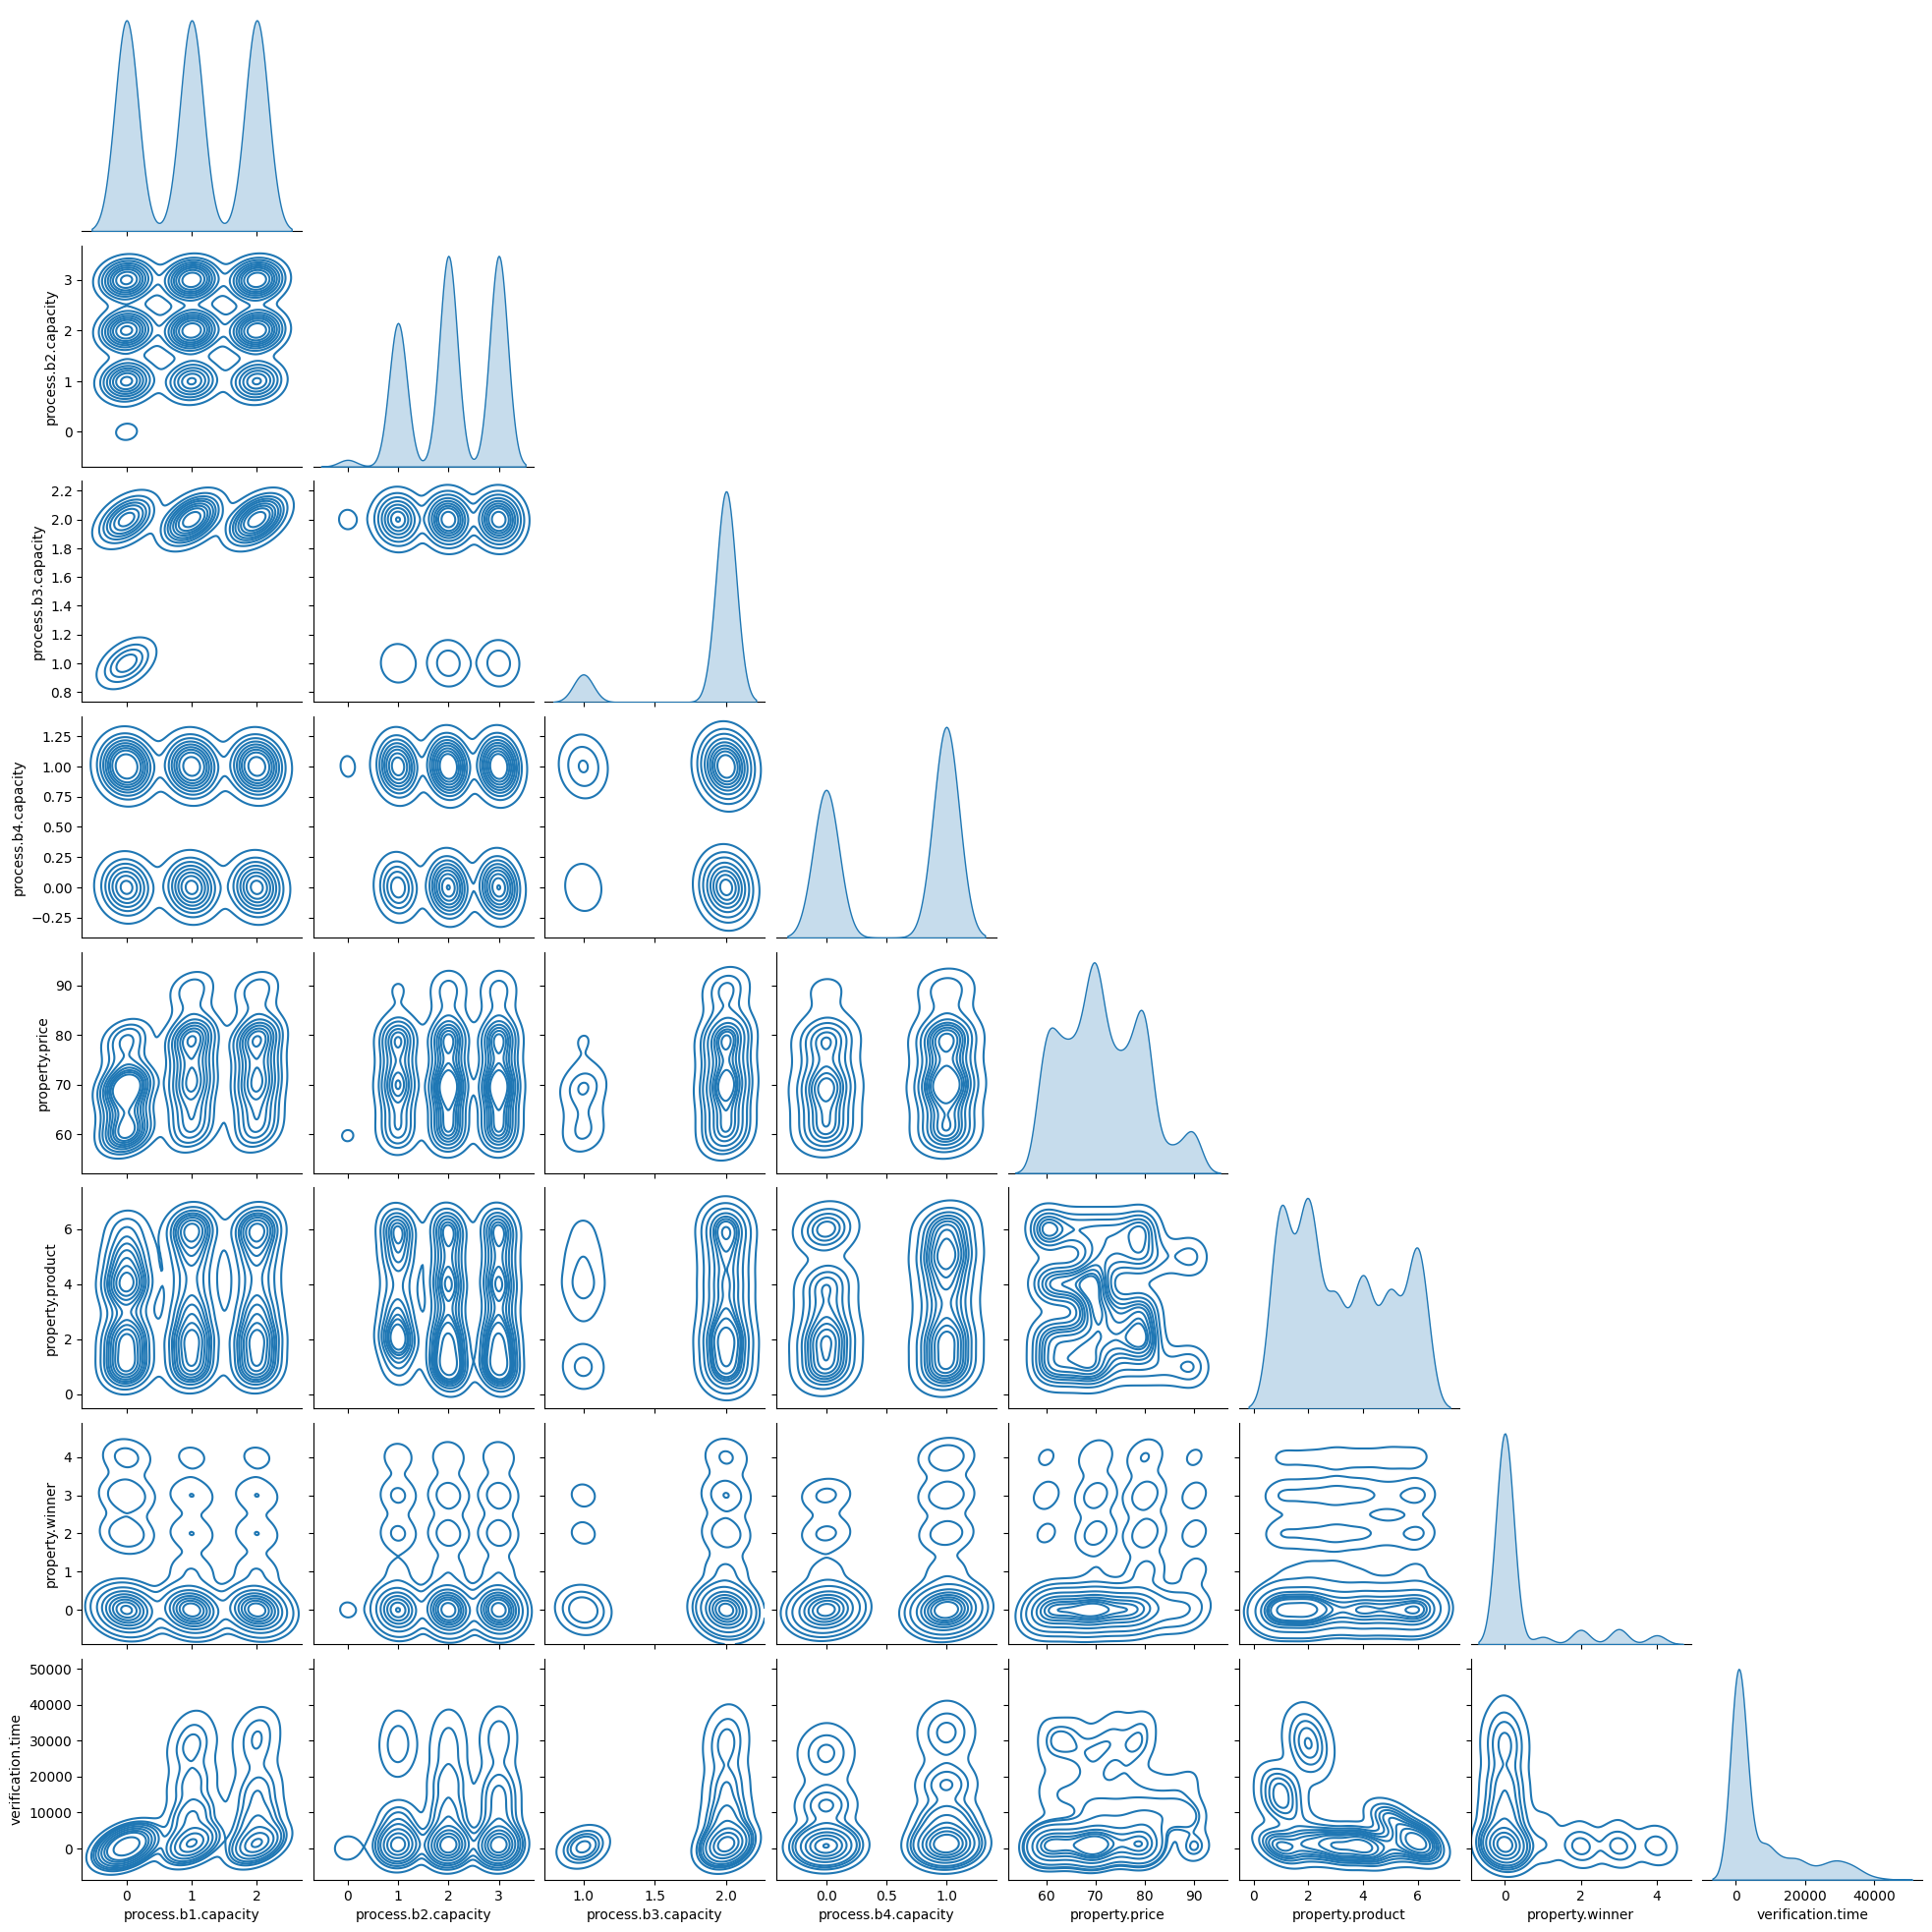

In [65]:
features=['process.b1.capacity',
          'process.b2.capacity',
          'process.b3.capacity',
          'process.b4.capacity',
          'property.price',
          'property.product',
          'property.winner',
          'verification.time']
sns.pairplot(df[features], kind="kde",corner=True)

** From the kernel density distribution above, we can see that it is most likely that auctions will take 7 days and then 3 days and 5 days. As is shown below, most auction types are 7 days. And this corresponds to the likihood of days most auctions** 

In [28]:
mean_vartime = df.groupby(['verification.result']).mean()
mean_vartime.head

<bound method NDFrame.head of                      process.b1.capacity  process.b2.capacity  \
verification.result                                             
0                               1.037619             2.107805   
1                               0.744275             2.000000   

                     process.b3.capacity  process.b4.capacity  property.price  \
verification.result                                                             
0                               1.892757             0.586188       70.819764   
1                               1.824427             0.599237       75.916031   

                     property.product  property.winner  verification.time  
verification.result                                                        
0                            3.226839         0.367771        8260.308913  
1                            3.423664         1.049618        1060.181647  >

In [27]:
max_vartime = df.groupby(['verification.result']).max()
max_vartime.head

<bound method NDFrame.head of                      process.b1.capacity  process.b2.capacity  \
verification.result                                             
0                                      2                    3   
1                                      2                    3   

                     process.b3.capacity  process.b4.capacity  property.price  \
verification.result                                                             
0                                      2                    1              90   
1                                      2                    1              90   

                     property.product  property.winner  verification.time  
verification.result                                                        
0                                   6                4       44130.520833  
1                                   6                4        8841.125000  >

- there is very small difference between ,corresponding features
- the most visible difference shows the following features: process.b1.capacity, property.price, property.winner
- max varification time shows some difference that we can use

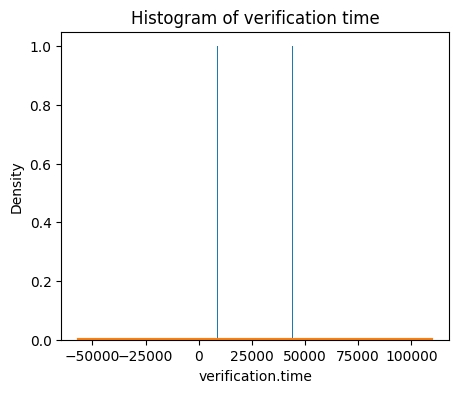

In [36]:
# when normed=True, sum of bin height*width for all bins=1
fig, ax = plt.subplots(figsize = (5, 4))
ax.hist(max_vartime['verification.time'], bins=150)
sns.kdeplot(max_vartime['verification.time'], ax=ax, lw = 3)
ax.set_title("Histogram of verification time")
plt.show()

- we can see from this plot that in average it take the same time for varification. Therefore we can remove this feature from analysis 

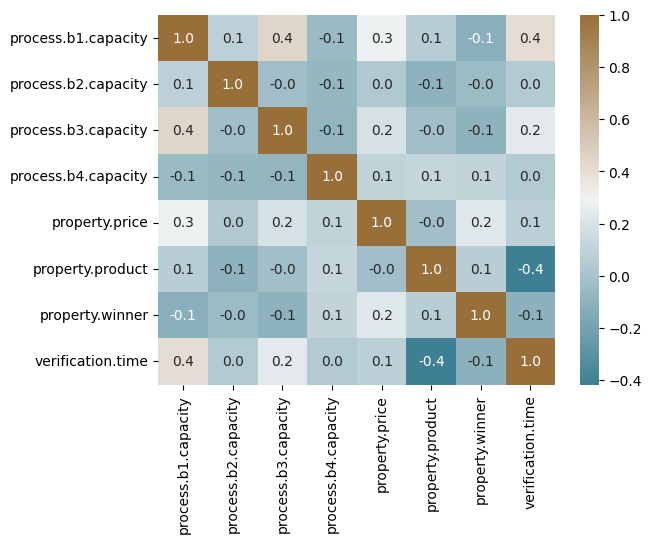

In [15]:
sns.heatmap(df.drop(columns=['verification.result']).corr(), annot=True, fmt='.1f', cmap=sns.diverging_palette(220, 50, as_cmap=True));

- there is no features that has good correlation 
- small correlation between varification time and process b1 capacity
- small correlation between process 1 capacity and process 3 capasity

In [96]:
# let is make new features 

#df['price_class'] = df['property.price'].apply(lambda value: (0 if value <= 60 else (1 if value <= 75 else 2)))
#df['price_class'] = pd.Categorical(df['price_class'], categories=[0,1,2])
#print(df['price_class'].value_counts())

df['time_class'] = df['verification.time'].apply(lambda value: (0 if value <= 680 else 1))
df['time_class'] = pd.Categorical(df['time_class'], categories=[0,1])
print(df['time_class'].value_counts())

time_class
1    1409
0     634
Name: count, dtype: int64


from the plot corresponding 'varification-time' we can noticed that there is signal difference that could be used to split data (this was made in Excel)

In [140]:
features2=['process.b1.capacity','property.winner','time_class','property.price','verification.time']

features3=['process.b1.capacity',
          'process.b2.capacity',
          'process.b3.capacity',
          'process.b4.capacity',
          'property.price',
          'property.product',
          'property.winner',
          'time_class']

features4=['process.b1.capacity','property.winner']

### Training set with re-sampling of the target classes

In [184]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.datasets import make_classification

## Normalization of the features ##################################
# norm = StandardScaler()
norm = MinMaxScaler()
X = norm.fit_transform(df[features2])
y = df['verification.result']


# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# concatenate our training data back together
X_train = pd.DataFrame(X_train,columns = features2)
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()
print(df_train['verification.result'].value_counts())

verification.result
0.0    1339
1.0     193
Name: count, dtype: int64


### Undersampling
our dataset has large amount of data. We can drop some data to balance training dataset
We will again use the resampling module from Scikit-Learn to randomly remove samples from the majority class

verification.result
1.0    193
0.0    193
Name: count, dtype: int64


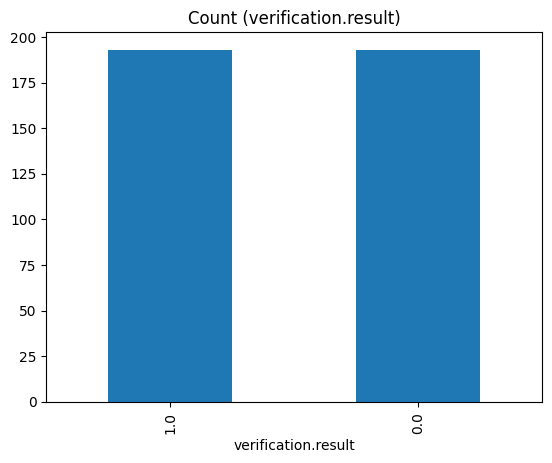

In [185]:
# separate minority and majority class
df_train_0 = df_train[df_train['verification.result']==0]
df_train_1 = df_train[df_train['verification.result']==1]

# downsample majority
downsampled_0 = resample(df_train_0,
                                replace = False, # sample without replacement
                                n_samples = len(df_train_1), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
df_train_down = pd.concat([df_train_1, downsampled_0])
# checking counts
print(df_train_down['verification.result'].value_counts())

df_train_down['verification.result'].value_counts().plot(kind='bar', title='Count (verification.result)');


### Training

In [210]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

##########################################################################
y=df['verification.result']
X=norm.fit_transform(df[features])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
X=X_train
y=y_train
X_train = pd.DataFrame(X_train)


start = time()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
booster = xgb.XGBRegressor(tree_method="approx", enable_categorical=True, eta=0.3, max_depth=3, n_estimators=11)

rmse_scores = cross_val_score(booster, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()
acc_score = cross_val_score(booster, X, y, scoring='accuracy', cv=kf, n_jobs=-1)

mean_speed = np.round(time() - start, 3)
mean_acc = np.mean(score).round(3)

print('Result corresponding original dataset')
print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Mean accurasy: {mean_acc:.2f}")
print(f"Mean speed: {mean_speed:.2f}")


Result corresponding original dataset
Mean RMSE: 0.14
Mean accurasy: 0.98
Mean speed: 0.12


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
  

In [186]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

##########################################################################
X = df_train_down[features2]
y = df_train_down['verification.result']


start = time()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
booster = xgb.XGBRegressor(tree_method="approx", enable_categorical=True, eta=0.3, max_depth=3, n_estimators=11)

rmse_scores = cross_val_score(booster, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()
acc_score = cross_val_score(booster, X, y, scoring='accuracy', cv=kf, n_jobs=-1)

mean_speed = np.round(time() - start, 3)
mean_acc = np.mean(score).round(3)

print('Result corresponding original dataset with reduced features and balancing classes')
print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Mean accurasy: {mean_acc:.2f}")
print(f"Mean speed: {mean_speed:.2f}")




Result corresponding original dataset with reduced features and balancing classes
Mean RMSE: 0.52
Mean accurasy: 0.98
Mean speed: 0.14


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
  

Result corresponding original dataset:
- Mean RMSE: 0.14
- Mean accurasy: 0.98
- Mean speed: 0.21

Result corresponding original dataset using features4 and class balancing (no data normalization):
- Mean RMSE: 0.42
- Mean accurasy: 0.98
- Mean speed: 0.14

Result corresponding original dataset using features4 and class balancing (MinMax, StandardScaler):
- Mean RMSE: 0.52
- Mean accurasy: 0.98
- Mean speed: 0.14

Result corresponding original dataset with estimated best parameters used for classification
- Mean RMSE: 0.18
- Mean accurasy: 0.98
- Mean speed: 0.99

### Hyperparameters tuning

In [211]:
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}

   - classifier : Default instance of XGBoost classifier
   - param_distributions : parameters to be passed
   - scoring : scoring attribute
   - n_iter : Number of iterations
   - n_jobs : Number of cores to be used(-1 indicates all the cores)
   - cv : cross validation
   - verbose : To generate messages while training the model

In [212]:
#Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost
#classifier = xgboost.XGBClassifier()

rs_model=RandomizedSearchCV(booster,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [214]:
#model fitting
rs_model.fit(X,y)

#parameters selected
rs_model.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7;, score=0.989 total time=   0.0s
[CV 2/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.3, max_depth=15, min_child_weight=5;, score=0.998 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=3;, score=0.999 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=3;, score=0.999 total time=   0.0s
[CV 4/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=8, min_child_weight=5;, score=nan total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=7;, score=0.107 total time=   0.0s
[CV 3/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=7;, score=0.131 total time=   0.0s
[CV 4/5] END colsample_bytre

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=True, eta=0.3, eval_metric=None,
             feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=11, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

### check the result of the classification using recommended parameters

In [216]:
start = time()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = cross_val_score(rs_model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()
acc_score = cross_val_score(booster, X, y, scoring='accuracy', cv=kf, n_jobs=-1)

mean_speed = np.round(time() - start, 3)
mean_acc = np.mean(score).round(3)

print('Result obtained for original dataset with estimated best parameters')
print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Mean accurasy: {mean_acc:.2f}")
print(f"Mean speed: {mean_speed:.2f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=5;, score=0.995 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=5;, score=0.995 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=7;, score=0.996 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.2, max_depth=8, min_child_weight=1;, score=0.998 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.1, max_depth=15, min_child_weight=1;, score=0.992 total time=   0.0s
[CV 5/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=5;, score=0.99

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 95, in _check_targets
  

[CV 5/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=12, min_child_weight=3;, score=0.999 total time=   0.0s
[CV 1/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=1;, score=1.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=7;, score=0.994 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=7;, score=0.996 total time=   0.0s
[CV 4/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=7;, score=0.999 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=7;, score=0.998 total time=   0.0s
[CV 1/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.3, max_depth=4, min_child_weight=3;, score=0.999 total time=   0.0s
[CV 1/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.3, max_depth=8, min_child

### Conclusion
- XGBRegressor has been used for classification
- Dataset was no balanced
- downsampling did not have any impact on the classification accuracy
- feature engineering did not show visible improvement
- Dataset size gives the same result when only 4 features are used
- the best parameters search did not show visible improvement